# Automatic number plate recognition

## Problem statement and data introduction

### Case description

Nowadays, security has become one of the biggest concerns for any organization, and automation of such security is of great importance. For example, in the modern world, companies and organizations want to automate many tasks related to control and monitoring as much as possible. However, many of the existing solutions are still not reliable in real situations, usually depending on many limitations.

As a CV case, we propose to create a part of the automatic recognition system of vehicle license plates.

> Automatic/Automated License Plate Recognition, ALPR — This is the identification of a part of a vehicle that is suspected to be a license plate. In other words, it is an artificial intelligence technology that uses optical character recognition in images to read vehicle registration plates and create vehicle location data.

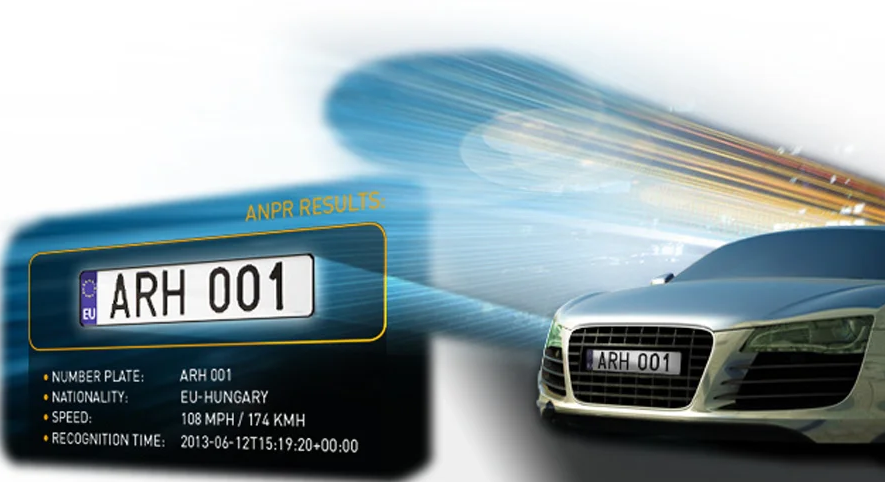

This technology typically uses traffic enforcement cameras or cameras specifically designed for this task.

ALPR technology is used in many areas, here are some examples:

* in parking lots to record license plates of parked cars;
* at checkpoints to record license plates of vehicles entering and leaving a business;
* by law enforcement on the road to identify vehicles violating traffic rules or to verify that a vehicle is registered or licensed;
* for traffic control and electronic toll collection on toll roads, such as by road agencies.

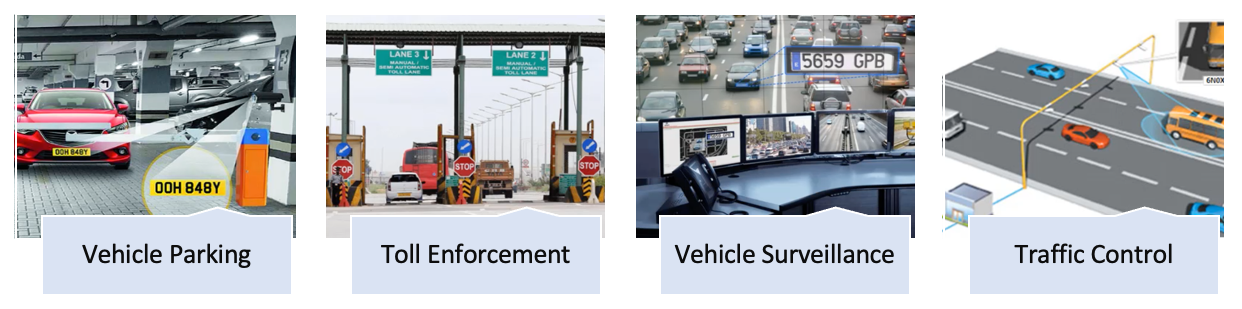

In general, to identify a vehicle license plate, the following steps must be completed:

* License plate detection in the image.<br>
At this stage, we need to develop an algorithm that will be responsible for finding and highlighting the license plate in the image. If we translate the task into Computer Vision terms, then, in essence, at this stage we need to build a model that solves the detection problem - highlighting the location of the license plate in the photo.

* Orientation and calibration of the license plate.<br>
At this stage, the skew of the license plate is compensated for and the size of the resulting image is corrected in accordance with the required size.

* Normalization.<br>
At this stage, the brightness and contrast of the image are adjusted to increase the likelihood of correct recognition of the text in the photo.

* Segmentation of characters. <br>
At this stage, we need to find individual characters on the license plates. That is, in essence, we need to break the text in the image into individual characters. In the case of printed text, where there is always some distance between the characters, this is a fairly simple task. But for handwritten text everything is much more complicated, here it is necessary to use specialized methods, but now is not about them.

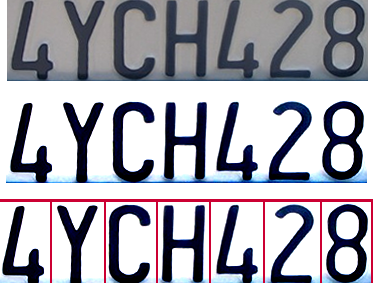

* Optical character recognition. <br>
When each character is selected, it needs to be recognized. This is far from a simple task. In essence, at this stage we convert the image of the license plate into a first approximation of the text.

* Syntactic/geometric analysis. <br>
After receiving the text, it needs to be checked for correctness. The characters and positions are checked for compliance with the specialized rules of a particular country.

* Averaging the recognized value. <br>
Making a decision based on one frame is a bad idea. The results can be greatly distorted due to the quality of the image, glare due to reflected light, incorrect angle, etc. Therefore, to obtain more accurate and reliable results, the recognition procedure (steps 1-6) is repeated several times.

The final result of the ALPR system is created by averaging the results of the algorithm for several images obtained at a certain time interval.

### About the dataset

To solve our problem, we need a dataset of images of cars from different angles and under different lighting conditions with the locations of license plates marked as bounding boxes.

To be specific, we will work with the [Car License Plate Detection](https://www.kaggle.com/datasets/andrewmvd/car-plate-detection) dataset, hosted on our favorite platform Kaggle.

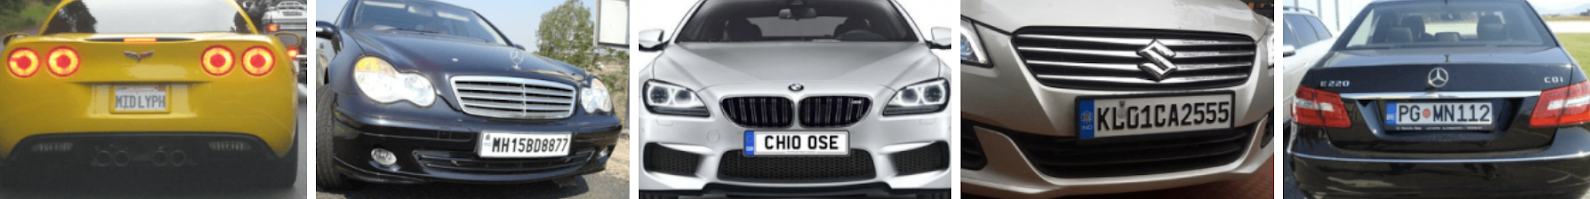

This dataset contains 433 unique images with annotations of the bounding boxes of the license plates within the image. Moreover, one image may contain several cars at once, and therefore several license plates.

The annotations are provided in the PASCAL VOC format.

### Getting to Know the Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torch
from sklearn.model_selection import train_test_split
import os
import glob
import xml.etree.ElementTree as ET 
from tqdm.auto import tqdm
import shutil as sh
import warnings
warnings.filterwarnings('ignore')

/home/estaid/miniconda3/envs/DL/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Let's check that the video card is available to us
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 4070 SUPER


In [ ]:
DATASET_PATH = "data"
ANNOTATIONS_PATH = os.path.join(DATASET_PATH, "annotations")
IMAGES_PATH = os.path.join(DATASET_PATH, "images")
print(ANNOTATIONS_PATH)
print(IMAGES_PATH)

data/annotations
data/images


Let's look at an example image. To display the image on the screen, we will use the imshow() function from the matplotlib library. To read the image, you need to pass the path to the image to it. The path can be relative (relative to the working directory) or absolute (set relative to the root directory of the project).

The result of reading will be a numpy array of dimension (HEIGHT, WIDTH, CHANNEL), where:

* HEIGHT - image height (in pixels)
* WIDTH - image width (in pixels)
* CHANNEL - number of channels

All images in the dataset are color, that is, they have three channels (consist of three two-dimensional matrices) - RGB (Red, Green, Blue). The values ​​of each of the three matrices are the pixel intensity values.

Image shape: (398, 530, 3)


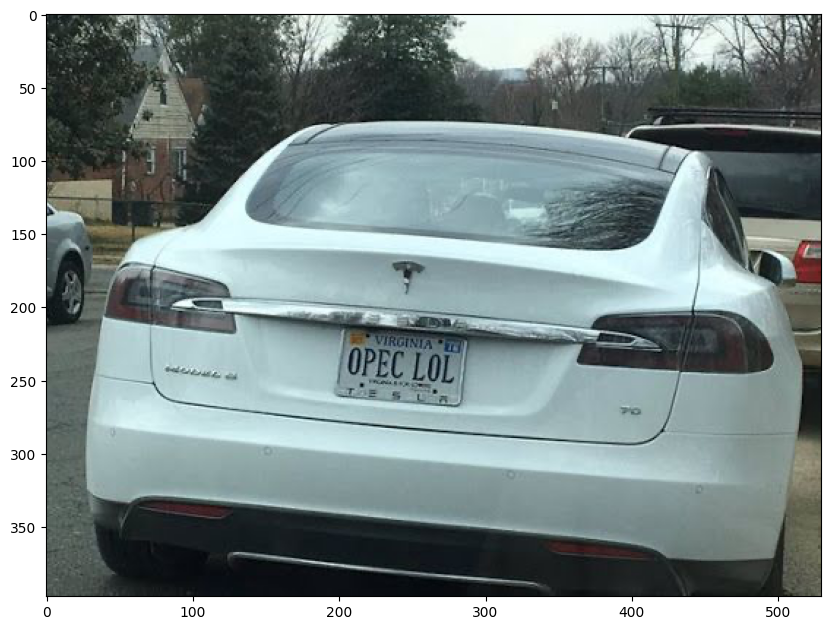

In [12]:
# Составляем путь до файла: /путь/до/папки/имя_изображения.png
image_filename = 'Cars129.png'
image_path = os.path.join(IMAGES_PATH, image_filename)
# Читаем изображение
img = plt.imread(image_path)
# Создаём фигуру и координатную плоскость
fig, ax = plt.subplots(figsize=(10, 8))
# Выводим изображение на экран
ax.imshow(img);
# Выводим размер изображения
print('Image shape: {}'.format(img.shape))

Now let's look at an example of annotation for this image.

In [ ]:
# Let's read one of the annotation files and look at its contents.
with open(os.path.join(ANNOTATIONS_PATH, 'Cars129.xml')) as f:
    print(f.read())


<annotation>
    <folder>images</folder>
    <filename>Cars129.png</filename>
    <size>
        <width>530</width>
        <height>398</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>licence</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>204</xmin>
            <ymin>213</ymin>
            <xmax>282</xmax>
            <ymax>267</ymax>
        </bndbox>
    </object>
</annotation>


When using PASCAL VOC format annotation, the following tags are specified:

* `<annotation>` - root title
* `<folder>` - folder with image
* `<filename>` - file name
* `<size>` - size information
* * `<width>` - width
* * `<height>` - height
* * `<depth>` - depth (number of channels)

* `<segmented>` - this field specifies information for segmentation. That is, whether the images contain non-linear (irregular) shaped annotations, usually called polygons (we do not have any, all frames are rectangular, so 0 is set)
* `<object>` - information for detecting objects
* * `<name>` - class name (in our case, license plate).
* * `<pose>` - specifies the asymmetry or orientation of the image. By default, it is specified as Unspecified, which means that the image is not distorted.
* * `<truncated>` - indicates whether the object is fully or partially visible (can be 0 or 1 respectively)
* * `<occluded>`- information about the absorption of classes by each other (this is when inside the bounding rectangle of class A, there is a bounding rectangle of class B)
* * `<difficult>` - Indicates whether it is difficult to recognize the object in the image (can be 0 - easy or 1 - difficult).
* * `<bndbox>` - these are the coordinates that determine the location of the object (in our case, the license plate). These coordinates are contained in the child tags `<xmin>`, `<ymin>`, `<xmax>`, `<ymax>`. The annotation stores the coordinates of the upper left and lower right positions of the object.

For further convenience, let's create a DataFrame in which we will store the following columns:

* *filename* - file name (without extension)
* *xmin*, *xmax* - minimum and maximum coordinates of the frame along the x axis
* *ymin*, *ymax* - minimum and maximum coordinates of the frame along the y axis
* *width*, *height* - width and height of the image

To do this, we will use the following code for parsing XML files with annotations:

In [ ]:
df_dict = {
    "filename":[], "xmin":[], "ymin":[],   
    "xmax":[],"ymax":[], "name":[],    
    "width":[], "height":[],
}

for annotation in glob.glob(ANNOTATIONS_PATH+"/*.xml"):
    tree = ET.parse(annotation)
    filename = tree.find('filename').text
    for elem in tree.iter():
        if 'size' in elem.tag:
            for attr in list(elem):
                if 'width' in attr.tag: 
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))    
        if 'object' in elem.tag:
            for attr in list(elem):
                if 'name' in attr.tag:
                    name = attr.text                 
                    df_dict['name'] += [name]
                    df_dict['width'] += [width]
                    df_dict['height'] += [height] 
                    df_dict['filename'] += [filename]
                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            df_dict['xmin'] += [xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            df_dict['ymin'] += [ymin]                                
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            df_dict['xmax'] += [xmax]                                
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            df_dict['ymax'] += [ymax]

In [17]:
df = pd.DataFrame(df_dict)
df.head()

filename  xmin  ymin  xmax  ymax     name  width  height
0   Cars50.png   116    55   525   262  licence    590     350
1   Cars89.png   307   206   345   221  licence    400     262
2   Cars89.png   227   222   253   230  licence    400     262
3  Cars155.png   150   177   203   190  licence    400     267
4  Cars156.png   114    78   230   102  licence    400     200

In [18]:
print('Data shape: {}'.format(df.shape))
print('Count of unique images: {}'.format(df['filename'].nunique()))
print('Count of classes: {}'.format(df['name'].unique()))

Data shape: (471, 8)
Count of unique images: 433
Count of classes: ['licence']


We see that we have 471 annotations in total, but fewer unique images - 433. This means that one image can contain several license plates at once. An important feature of the dataset!

We also see that we have only one class in the data - licence (license plate). This means that when performing detection, we will solve a binary classification problem - distinguish the class of the license plate from the background (everything that is not a license plate).

Now that we have parsed the coordinates of the bounding boxes, let's choose an image from the dataset and display it along with the annotation. That is, add a bounding box on top of the image.

[204] [213] [78] [54]


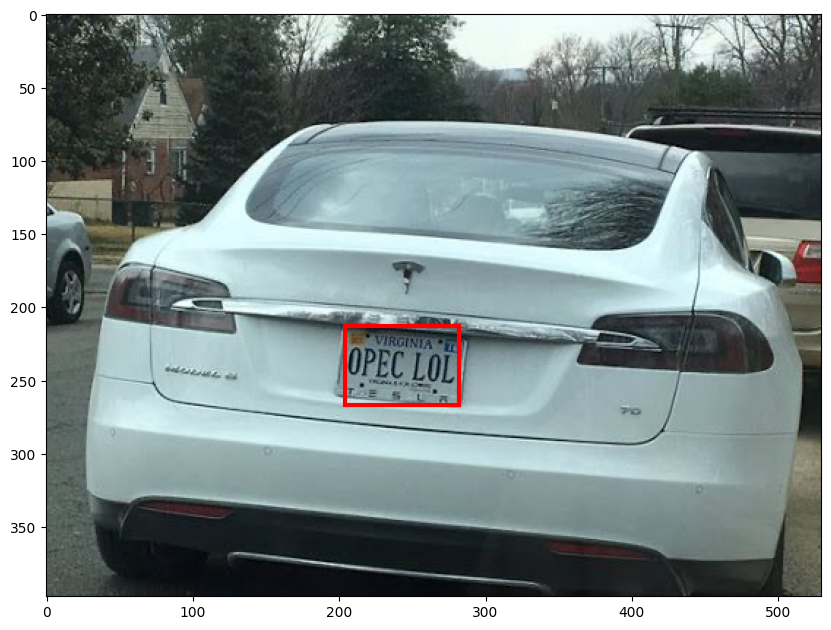

In [19]:
# Составляем путь до файла — /путь/до/папки/имя_изображения.png
image_filename = 'Cars129.png'
image_path = os.path.join(IMAGES_PATH, image_filename)
# Читаем изображение
img = plt.imread(image_path)
# Создаём фигуру и координатную плоскость
fig, ax = plt.subplots(figsize=(10, 8))
# Выводим изображение на экран
ax.imshow(img);

# Находим индекс картинки в DataFrame
image_idx = df[df['filename'] == image_filename].index

# Находим координаты левой нижней точки
x_min = df.loc[image_idx, 'xmin'].values
y_min = df.loc[image_idx, 'ymin'].values
# Находим ширину и высоту рамки
box_width = (df.loc[image_idx, 'xmax'] - df.loc[image_idx, 'xmin']).values
box_height = (df.loc[image_idx, 'ymax'] - df.loc[image_idx, 'ymin']).values
print(x_min, y_min, box_width, box_height)

# Так как ограничивающих прямоугольников может быть несколько, создаём цикл по всем.
for i in range(len(image_idx)):
    # Строим прямоугольник
    rect = patches.Rectangle(
        (x_min[i], y_min[i]), #координаты опорной точки
        box_width[i], #ширина прямоугольника
        box_height[i], #высота прямоугольника
        linewidth=3, #ширина линии
        edgecolor='r', #цвет
        facecolor='none' #заливка (none — отсутствует)
    )
    # Накладываем прямоугольник поверх изображения
    ax.add_patch(rect);

For the convenience of further work, we will wrap all this code for image visualization in a function, let's call it plot_bounding_box(). The function will accept the name of the file with the desired image and a DataFrame with coordinates and display the image on the screen:

In [ ]:
def plot_bounding_box(image_folder, image_filename, df=df):
    image_path = os.path.join(image_folder, image_filename)
    img = plt.imread(image_path)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(img);

    image_idx = df[df['filename'] == image_filename].index

    x_min = df.loc[image_idx, 'xmin'].values
    y_min = df.loc[image_idx, 'ymin'].values
    box_width = (df.loc[image_idx, 'xmax'] - df.loc[image_idx, 'xmin']).values
    box_height = (df.loc[image_idx, 'ymax'] - df.loc[image_idx, 'ymin']).values
    for i in range(len(image_idx)):
        rect = patches.Rectangle(
            (x_min[i], y_min[i]), 
            box_width[i], 
            box_height[i], 
            linewidth=3, 
            edgecolor='r', 
            facecolor='none'
        )
        ax.add_patch(rect);

Let's check how our code works for the case of several bounding boxes. Let's take the image 'Car330.png', substitute its name into the image_filename argument of the plot_bounding_box() function and get:

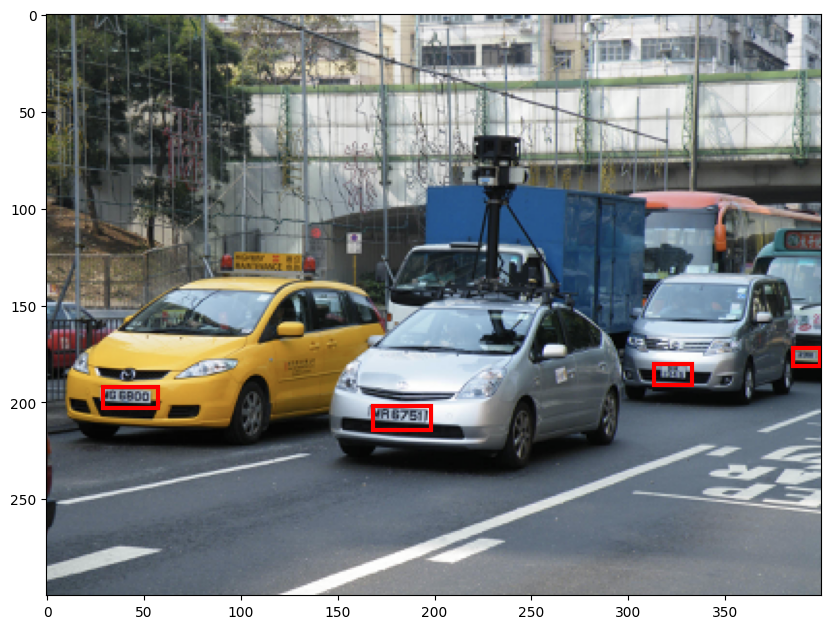

In [21]:
plot_bounding_box(image_folder=IMAGES_PATH, image_filename='Cars330.png', df=df)

Let's call the plot_bounding_box() function several times and look at the images. For example, let's call the function three times on three random images (you can specify any number):

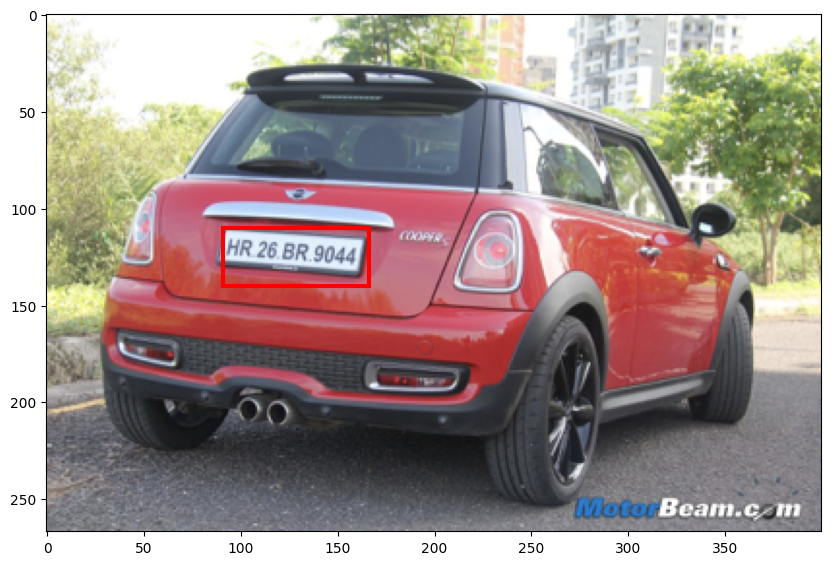

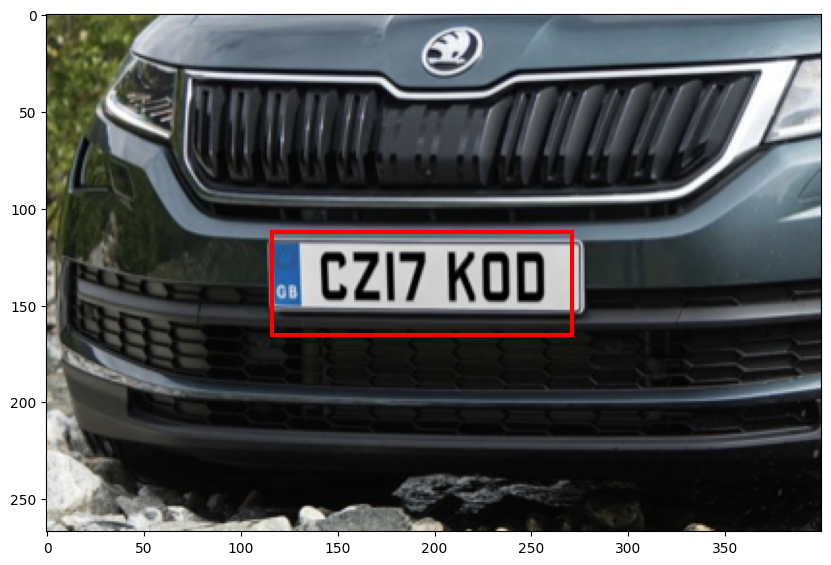

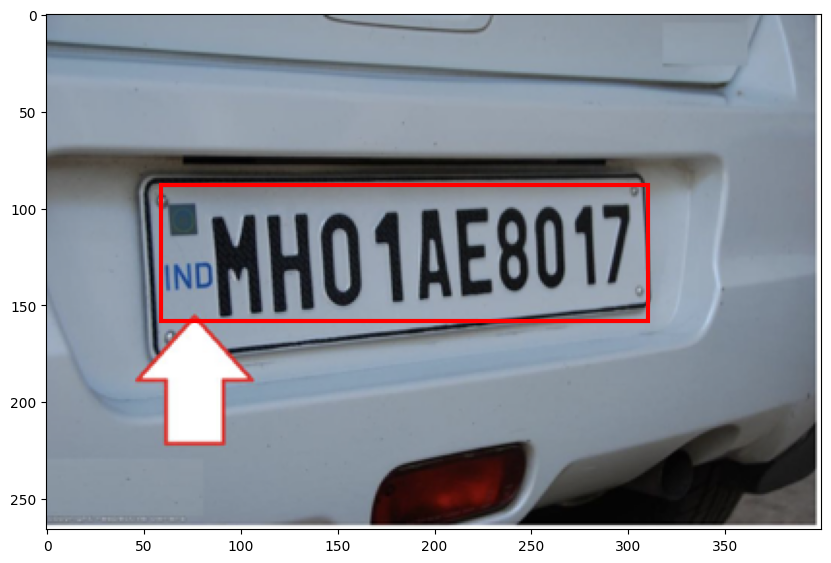

In [22]:
count = 3
for i in range(count):
    random_image_idx = np.random.choice(df.shape[0])
    image_filename = df.loc[random_image_idx, 'filename']
    plot_bounding_box(IMAGES_PATH, image_filename, df)